In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,54308,None,None,85824.192692
2020-06-13,54309,None,None,79712.293147
2020-06-14,54310,None,None,74044.049003
2020-06-15,54311,None,None,68704.218862
2020-06-16,54312,None,None,63945.659557
...,...,...,...,...
2021-05-02,54632,None,None,15397.888665
2021-05-03,54633,None,None,15188.723419
2021-05-04,54634,None,None,15038.802375


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-05-06_2021-05-06-16-39.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-05-05_2021-05-05-18-59.pickle


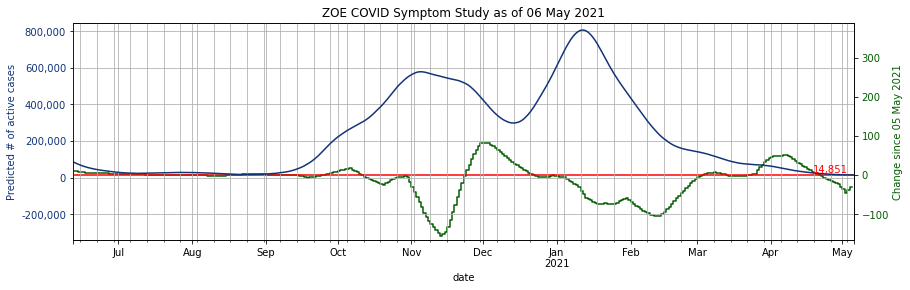

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

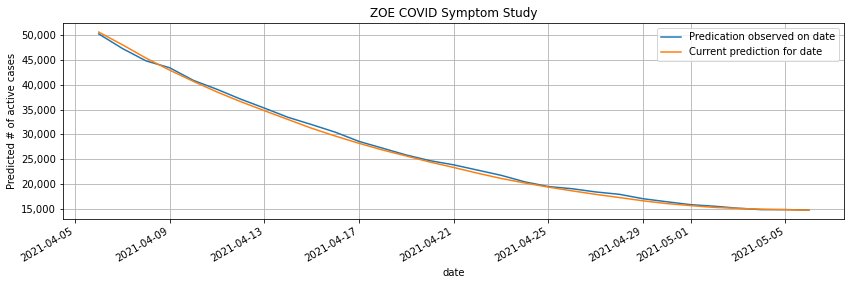

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-05-06_2021-05-06-16-39.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
297,Falkirk,S12000014,0.320161
299,Wolverhampton,E08000031,0.246403
324,East Dunbartonshire,S12000045,0.190059
15,"Kingston upon Hull, City of",E06000010,0.184839
105,Erewash,E07000036,0.184085
302,Kirklees,E08000034,0.184078
323,North Lanarkshire,S12000044,0.154149
266,Bolton,E08000001,0.149882
6,North East Derbyshire,E07000038,0.117505
5,York,E06000014,0.108099
